# Library and Configuration

In [171]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
import lmfit
import seaborn as sns
from lmfit.models import GaussianModel
try:
    from Detect_peaks import detect_peaks
except Exception as ep:
    print (ep)
    def detect_peaks(y,mph,mpd=10):
        from peakutils import indexes
        return indexes(y, thres=mph, min_dist=mpd) 
from glob import glob1
import os
import pandas as pd
from Binning_scipy import bin_edge2_bin_center,bin_data_given_bin_center
from theoretical_ion_spacings import theoretical_ion_spacing_um

def Gaussian_fit(x,y,yerr=None,guess_params=None):
    mod = GaussianModel()
    if guess_params is None:
        params = mod.guess(y,x=x)
    else:
        params = mod.make_params(amplitude = guess_params[0], center = guess_params[1], gamma = guess_params[2])
    if yerr is None:
        result = mod.fit(y,params,x=x, nan_policy='omit')
    else:
        result = mod.fit(y,params,x=x,weights=yerr, nan_policy='omit')
    return result, mod

def binomial_mean_err(success_event, num_trials, confidence_interval=0.6827):
    try:
        if success_event <1:
            mean_val = success_event
        else:
            mean_val = success_event/num_trials
    except:
        if success_event[0] <1:
            mean_val = success_event
        else:
            mean_val = success_event/num_trials
    alpha = 1- confidence_interval
    err = (1-alpha/2)*np.sqrt((mean_val*(1-mean_val))/num_trials)
    return mean_val, err
    
def fasterloadtxt(filename,flatten=False,skiprows=None, sep=' '):
    '''
    using pandas to speed up file reading
    '''
    df = pd.read_csv(filename,sep=sep, skiprows=skiprows, header=None)
    if flatten:
        return df.values.flatten()
    else:
        return df.values

No module named 'Detect_peaks'


In [172]:
import matplotlib
textsize = 20
matplotlib.rcParams.update({'font.size': textsize})
matplotlib.rcParams['lines.linewidth'] = 3
matplotlib.rcParams['font.family']='arial'
params = {'legend.edgecolor': '0',
          'lines.markersize' : 6,
          'legend.borderaxespad': 1.5,
          'legend.fancybox': False,
          'legend.fontsize': textsize*0.9,
          'legend.framealpha': 0.5,
          'legend.labelspacing': 0.3,
          'legend.markerscale': 1.0,
          'figure.figsize': (10, 8),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'axes.linewidth': 3,
         'axes.xmargin': 0.03,
         'axes.ymargin': 0.03,
         'xtick.direction': 'in',
         'xtick.labelsize': textsize,
         'xtick.major.pad': 10,
         'xtick.major.size': 10,
         'xtick.major.width': 3,
         'xtick.minor.pad': 10,
         'xtick.minor.size': 5,
         'xtick.minor.visible': True,
         'xtick.minor.width': 2,
         'xtick.top': True,
         'ytick.direction': 'in',
         'ytick.labelsize': textsize,
         'ytick.major.pad': 10,
         'ytick.major.size': 10,
         'ytick.major.width': 3,
         'ytick.minor.pad': 10,
         'ytick.minor.size': 5,
         'ytick.minor.visible': True,
         'ytick.minor.width': 2,
         'ytick.right': True,}
plt.rcParams.update(params)


In [173]:
color_lst = sns.color_palette("Paired")
color_lst1 = sns.color_palette("rocket_r",  n_colors=8, as_cmap=False)
color_lst2 = sns.color_palette("Set2")

# Read_camera images taken from ccd camera

In [174]:
# 2d gaussian fit

def gaussian_2d(xy_mesh, amp, xc, yc, sigma_x, sigma_y, con):
    
    # unpack 1D list into 2D x and y coords
    (x, y) = xy_mesh
    
    # make the 2D Gaussian matrix
    gauss = amp*np.exp(-((x-xc)**2/(2*sigma_x**2)+(y-yc)**2/(2*sigma_y**2)))/(2*np.pi*sigma_x*sigma_y) + con
    
    # flatten the 2D Gaussian down to 1D
    return np.ravel(gauss)

def sample_xyz_data(xarray,yarray,zarray, xstart, xend, ystart, yend):
    sampled_x = []
    sampled_y = []
    sampled_z = []
    for j in range(len(xarray)):
        for k in range(len(yarray)):
            if xarray[j] <= xend and xarray[j] >= xstart and yarray[k] <= yend and yarray[k] >= ystart:
                sampled_z.append(zarray[j][k])
                sampled_x.append(xarray[j])
                sampled_y.append(yarray[k])
    sampled_x = np.sort(np.array(list(set(sampled_x))))
    sampled_y = np.sort(np.array(list(set(sampled_y))))
    sampled_z = np.array(sampled_z).reshape((sampled_x.shape[0],sampled_y.shape[0]))
    return np.sort(sampled_x),np.sort(sampled_y),sampled_z

def gaussian_2d_fit(x,y,z,guess_params=[1,0,0,0.5,0.5,0],isprint=False):
    model = Model(gaussian_2d)
    params = model.make_params(amp=guess_params[0],
                               xc=guess_params[1],
                               yc=guess_params[2],
                               sigma_x=guess_params[3],
                               sigma_y=guess_params[4],
                               con  = guess_params[5]
                              )
    params['con'].set(vary=False)
    result = model.fit(z,params,xy_mesh = np.meshgrid(x,y))
    if isprint:
        print (result.fit_report())
    return result, model

def separation(lmfit1,lmfit2):
    sx = lmfit1.params['xc'].value - lmfit2.params['xc'].value
    dsx = sx*np.sqrt((lmfit1.params['xc'].stderr/lmfit1.params['xc'].value)**2+(lmfit2.params['xc'].stderr/lmfit2.params['xc'].value)**2)
    sy = lmfit1.params['yc'].value - lmfit2.params['yc'].value
    dsy = sy*np.sqrt((lmfit1.params['yc'].stderr/lmfit1.params['yc'].value)**2+(lmfit2.params['yc'].stderr/lmfit2.params['yc'].value)**2)
    mean = ((sx)**2 + (sy)**2)**(0.5)
    std = (sx*dsx + sy*dsy)/(mean)
    return mean,std

def contour_level_from_fit(lmfit):
    xc = lmfit.params['xc'].value
    sigma_x = lmfit.params['sigma_x'].value
    yc = lmfit.params['yc'].value
    sigma_y = lmfit.params['sigma_y'].value
    sigma_x_pts = xc + [sigma_x, 2*sigma_x, 3*sigma_x]
    sigma_y_pts = yc + [sigma_y, 2*sigma_y, 3*sigma_y]
    sigma_xy_mesh = np.meshgrid(sigma_x_pts, sigma_y_pts)

    contour_levels = Model(gaussian_2d).eval(params=lmfit.params,xy_mesh=sigma_xy_mesh).reshape(sigma_xy_mesh[0].shape)
    contour_levels = list(np.diag(contour_levels)[::-1])
    
    labels = {}
    label_txt = [r'$3\sigma$', r'$2\sigma$', r'$1\sigma$']
    for level, label in zip(contour_levels, label_txt):
        labels[level] = label
    
    return contour_levels,labels

In [175]:
directory = r'Z:\qfc\measurements\general\2023\Camera_Pictures'
flst = ['16022023_IonShuttling_6tom6V.asc']

2 peaks are separated by 64.730 +- 0.016 pixel
Using 0.860 um/pixel, 2 peaks are separated by 55.668 +- 0.014 um
Pictures taken at voltage -6 and 6 V. This gives 4.639 +- 0.001 um/V


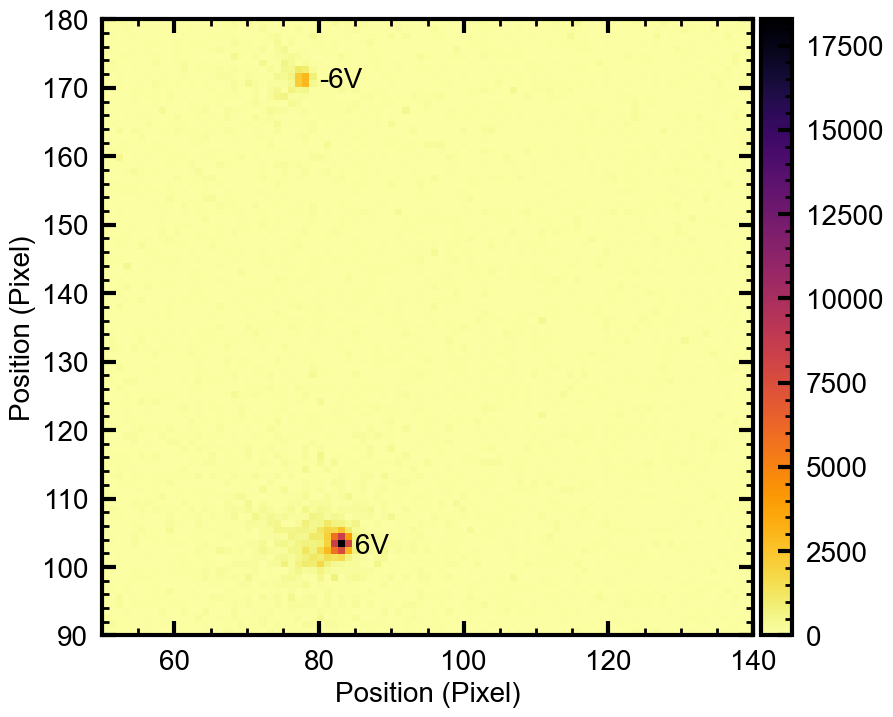

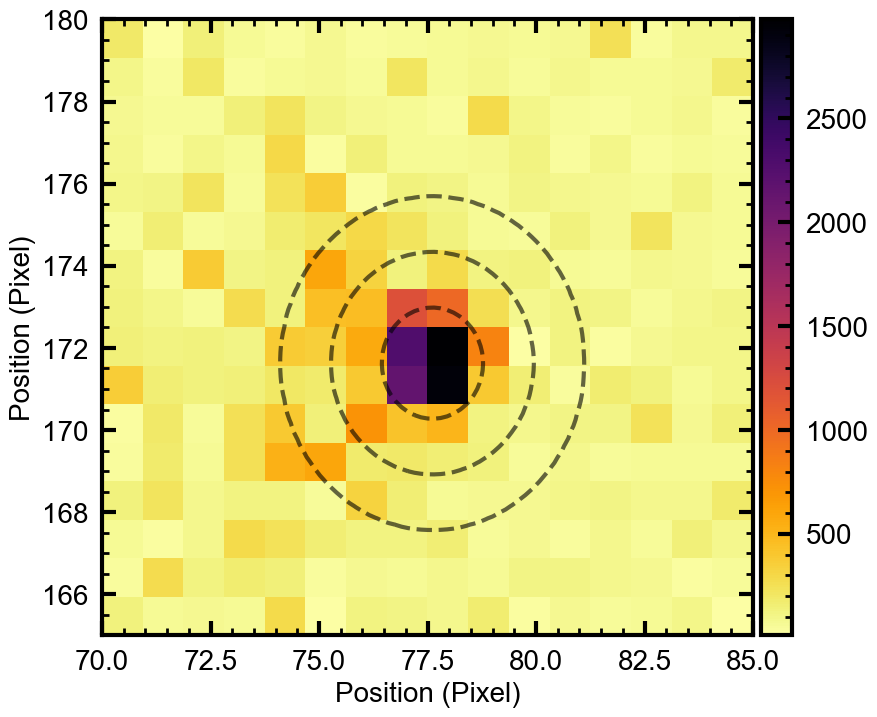

In [169]:
filename = os.path.join(directory,flst[0])
data = fasterloadtxt(filename, sep=',')
camera_data = abs(data[:,1:-1] - 109)
dimx,dimy =  camera_data.shape
xarray = np.arange(dimx)
yarray = np.arange(dimy)
pixel_um =  0.86
    
xstart = 50
xend = 140
ystart = 90
yend = 180


sampled_x,sampled_y,sampled_z = sample_xyz_data(xarray,yarray,camera_data,xstart,xend,ystart,yend)

f = plt.figure()
ax  =f.add_subplot(111)
im = ax.pcolorfast(sampled_x ,sampled_y,sampled_z.T, cmap='inferno_r')
cb = f.colorbar(im,ax=ax,pad=0.01)
ax.set_xlabel(r'Position (Pixel)')
ax.set_ylabel(r'Position (Pixel)')
ax.text(80,170,'-6V')
ax.text(85,102,'6V')
# f.savefig(filename[:-4]+'_position_12.png',dpi=300,bbox_inches='tight',facecolor='white')


# position_1

xstart = 70
xend = 90
ystart = 95
yend = 115


sampled_x,sampled_y,sampled_z = sample_xyz_data(xarray,yarray,camera_data,xstart,xend,ystart,yend)

f = plt.figure()
ax  =f.add_subplot(111)
im = ax.pcolorfast(sampled_x ,sampled_y,sampled_z.T, cmap='inferno_r')
cb = f.colorbar(im,ax=ax,pad=0.01)
ax.set_xlabel(r'Position (Pixel)')
ax.set_ylabel(r'Position (Pixel)')


result, model = gaussian_2d_fit(sampled_x ,sampled_y,np.ravel(sampled_z),guess_params=[10500,82,102,0.5,0.5,0.])
contour_level, labels =contour_level_from_fit(result)

xpix,ypix = np.meshgrid(np.linspace(xstart,xend,101),np.linspace(ystart,yend,101))
bestfit = model.eval(result.params,xy_mesh = np.meshgrid(np.linspace(xstart,xend,101),np.linspace(ystart,yend,101)))
ax.contour(xpix,ypix,bestfit.reshape((xpix.shape[0],ypix.shape[0])).T,colors='black',alpha=0.6,levels=contour_level,linestyles ='dashed')

# position_2

xstart = 70
xend = 85
ystart = 165
yend = 180


sampled_x,sampled_y,sampled_z = sample_xyz_data(xarray,yarray,camera_data,xstart,xend,ystart,yend)

f = plt.figure()
ax  =f.add_subplot(111)
im = ax.pcolorfast(sampled_x ,sampled_y,sampled_z.T, cmap='inferno_r')
cb = f.colorbar(im,ax=ax,pad=0.01)
ax.set_xlabel(r'Position (Pixel)')
ax.set_ylabel(r'Position (Pixel)')

result1, model = gaussian_2d_fit(sampled_x ,sampled_y,np.ravel(sampled_z),guess_params=[1500,77,172,0.5,0.5,0])
contour_level, labels =contour_level_from_fit(result1)

xpix,ypix = np.meshgrid(np.linspace(xstart,xend,101),np.linspace(ystart,yend,101))
bestfit = model.eval(result1.params,xy_mesh = np.meshgrid(np.linspace(xstart,xend,101),np.linspace(ystart,yend,101)))
ax.contour(xpix,ypix,bestfit.reshape((xpix.shape[0],ypix.shape[0])).T,colors='black',alpha=0.6,levels=contour_level,linestyles ='dashed')


sep, dsep = separation(result,result1)
print ('2 peaks are separated by {:.3f} +- {:.3f} pixel'.format(sep, dsep))
print ('Using {:.3f} um/pixel, 2 peaks are separated by {:.3f} +- {:.3f} um'.format(pixel_um, pixel_um*sep, pixel_um*dsep))
print ('Pictures taken at voltage -6 and 6 V. This gives {:.3f} +- {:.3f} um/V'.format(pixel_um*sep/12, pixel_um*dsep/12))

# Get images from .npz data from cam_software

In [176]:
directory0= r'Z:\qfc\measurements\cam_data\2023-02-09\153258'
directory1 =r'Z:\qfc\measurements\cam_data\2023-02-16\150409'
flst0 = glob1(directory0,'**.npz')
flst = glob1(directory1,'**.npz')

## 2ion case

11 11 (11, 11)
2 peaks are separated by 11.340 +- 0.051 pixel
2 peaks are separated by 28.879 +- 0.129 pixel
2-ion string at 582 kHz axial, separation is 8.0363597 um
This gives the conversion factor of 0.709 +- 0.003 um/pixel
Shuttled distance is 24.836 +- 0.092 um


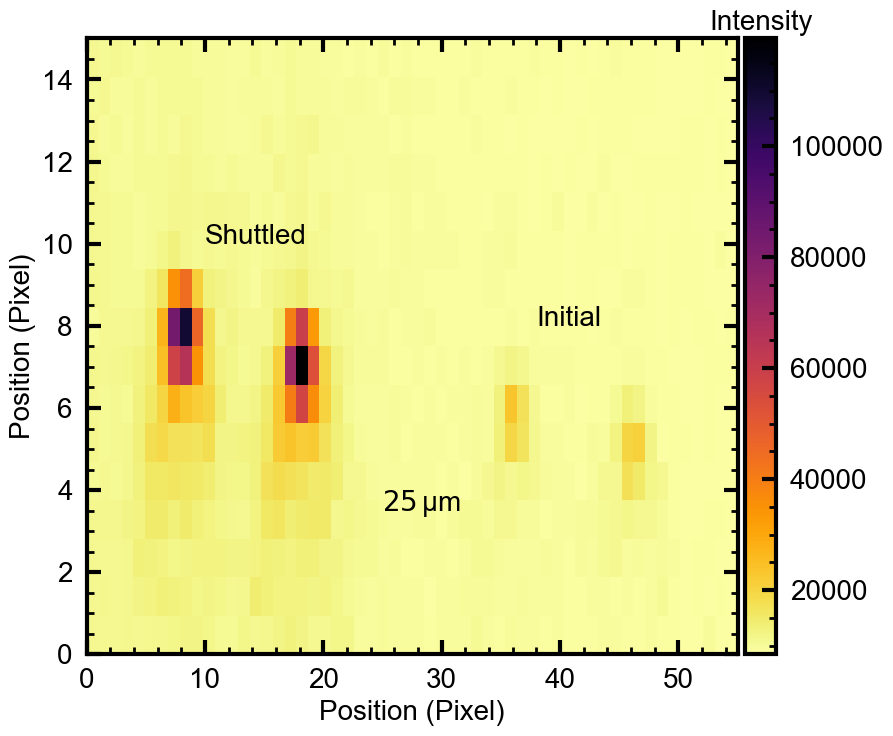

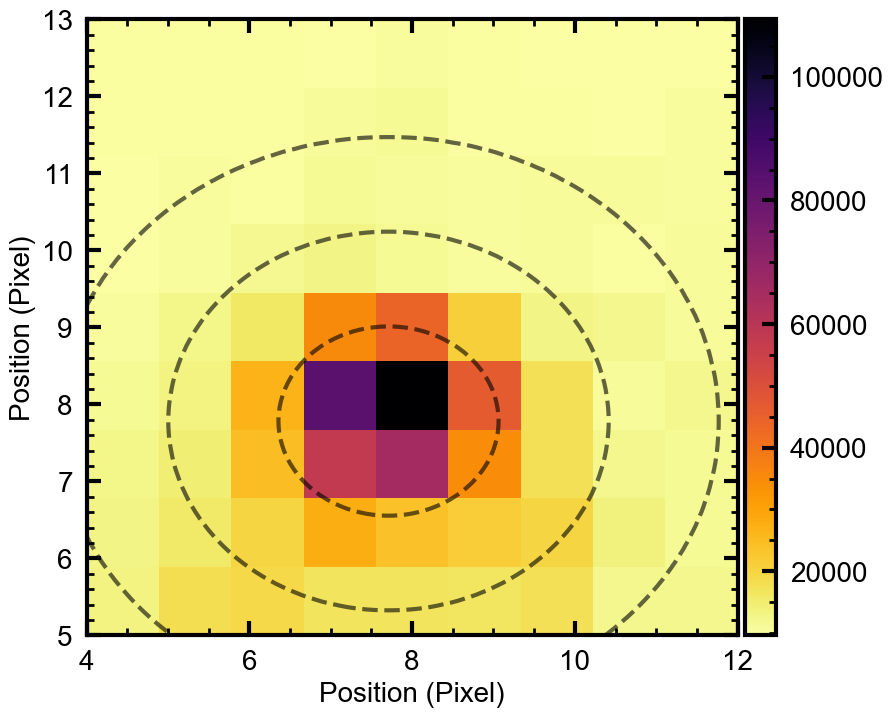

In [177]:
j = 0
filename = os.path.join(directory1,flst[j])
data = np.load(filename)
image_array = data['image_array']
pixel_x = np.arange(image_array[0].shape[0])
pixel_y = np.arange(image_array[0].shape[1])
cummulative_image = image_array.sum(axis=0)

f = plt.figure()
ax  =f.add_subplot(111)
im = ax.pcolorfast(pixel_x,pixel_y,cummulative_image.T, cmap='inferno_r')
cb = f.colorbar(im,ax=ax,pad=0.01)
cb.ax.set_title('Intensity')
ax.set_xlabel(r'Position (Pixel)')
ax.set_ylabel(r'Position (Pixel)')
ax.text(38, 8, 'Initial')
ax.text(10, 10, 'Shuttled')
ax.text(25,3.5,r'$25\,\mathregular{\mu m}$')
f.savefig(filename[:-4]+'_shuttled_summed.png',dpi=200,bbox_inches='tight',facecolor='white')
####

# position_1

xstart = 4
xend = 12
ystart = 5
yend = 13


sampled_x,sampled_y,sampled_z = sample_xyz_data(pixel_x,pixel_y,cummulative_image,xstart,xend,ystart,yend)

f = plt.figure()
ax  =f.add_subplot(111)
im = ax.pcolorfast(sampled_x ,sampled_y,sampled_z.T, cmap='inferno_r')
cb = f.colorbar(im,ax=ax,pad=0.01)
ax.set_xlabel(r'Position (Pixel)')
ax.set_ylabel(r'Position (Pixel)')

result, model = gaussian_2d_fit(sampled_x ,sampled_y,np.ravel(sampled_z),guess_params=[10500,8,8,0.5,0.5,min(np.ravel(sampled_z))])
contour_level, labels =contour_level_from_fit(result)

xpix,ypix = np.meshgrid(np.linspace(xstart,xend,101),np.linspace(ystart,yend,101))
bestfit = model.eval(result.params,xy_mesh = np.meshgrid(np.linspace(xstart,xend,101),np.linspace(ystart,yend,101)))
ax.contour(xpix,ypix,bestfit.reshape((xpix.shape[0],ypix.shape[0])).T,colors='black',alpha=0.6,levels=contour_level,linestyles ='dashed')

# position_2

xstart = 13
xend = 21
ystart = 2
yend = 10


sampled_x,sampled_y,sampled_z = sample_xyz_data(pixel_x,pixel_y,cummulative_image,xstart,xend,ystart,yend)

f = plt.figure()
ax  =f.add_subplot(111)
im = ax.pcolorfast(sampled_x ,sampled_y,sampled_z.T, cmap='inferno_r')
cb = f.colorbar(im,ax=ax,pad=0.01)
ax.set_xlabel(r'Position (Pixel)')
ax.set_ylabel(r'Position (Pixel)')

result1, model = gaussian_2d_fit(sampled_x ,sampled_y,np.ravel(sampled_z),guess_params=[1500,18,7,0.5,0.5,min(np.ravel(sampled_z))])
contour_level, labels =contour_level_from_fit(result1)

xpix,ypix = np.meshgrid(np.linspace(xstart,xend,101),np.linspace(ystart,yend,101))
bestfit = model.eval(result1.params,xy_mesh = np.meshgrid(np.linspace(xstart,xend,101),np.linspace(ystart,yend,101)))
ax.contour(xpix,ypix,bestfit.reshape((xpix.shape[0],ypix.shape[0])).T,colors='black',alpha=0.6,levels=contour_level,linestyles ='dashed')

# position_3

xstart = 31
xend = 41
ystart = 1
yend = 11

sampled_x,sampled_y,sampled_z = sample_xyz_data(pixel_x,pixel_y,cummulative_image,xstart,xend,ystart,yend)
print (len(sampled_x),len(sampled_y),(sampled_z).shape)
f = plt.figure()
ax  =f.add_subplot(111)
im = ax.pcolormesh(sampled_x ,sampled_y, sampled_z.T, cmap='inferno_r')
cb = f.colorbar(im,ax=ax,pad=0.01)
ax.set_xlabel(r'Position (Pixel)')
ax.set_ylabel(r'Position (Pixel)')

result2, model = gaussian_2d_fit(sampled_x ,sampled_y,np.ravel(sampled_z),guess_params=[max(np.ravel(sampled_z)),36,6,0.5,0.5,min(np.ravel(sampled_z))])
contour_level, labels =contour_level_from_fit(result2)

xpix,ypix = np.meshgrid(np.linspace(xstart,xend,101),np.linspace(ystart,yend,101))
bestfit = model.eval(result2.params,xy_mesh = np.meshgrid(np.linspace(xstart,xend,101),np.linspace(ystart,yend,101)))
ax.contour(xpix,ypix,bestfit.reshape((xpix.shape[0],ypix.shape[0])).T,colors='black',alpha=0.6,levels=contour_level,linestyles ='dashed')


sep, dsep = separation(result,result1)
sep1, dsep1 = separation(result,result2)
print ('2 peaks are separated by {:.3f} +- {:.3f} pixel'.format(sep, dsep))
print ('2 peaks are separated by {:.3f} +- {:.3f} pixel'.format(sep1, dsep1))
print ('2-ion string at 582 kHz axial, separation is 8.0363597 um')
print ('This gives the conversion factor of {:.3f} +- {:.3f} um/pixel'.format( 8.0363597/sep,  8.0363597*(dsep/sep)/sep))
print ('Shuttled distance is {:.3f} +- {:.3f} um'.format(sep1*0.86 , dsep1*8.0363597/sep ))
# print ('Using {:.3f} um/pixel, 2 peaks are separated by {:.3f} +- {:.3f} um'.format(pixel_um, pixel_um*sep, pixel_um*dsep))
# print ('Pictures taken at voltage -6 and 6 V. This gives {:.3f} +- {:.3f} um/V'.format(pixel_um*sep/12, pixel_um*dsep/12))


In [195]:
f = plt.figure()
ax  =f.add_subplot(111)
im = ax.pcolorfast(pixel_y,pixel_x,cummulative_image, cmap='inferno_r')
cb = f.colorbar(im,ax=ax,pad=0.01)
cb.ax.set_title('Intensity')
ax.set_xlabel(r'Position (Pixel)')
ax.set_ylabel(r'Position (Pixel)')
ax.text(8, 38, 'Initial')
ax.text(10, 10, 'Shuttled')
ax.text(3.5,25,r'$25\,\mathregular{\mu m}$')
ax.arrow(2.5, 35 , 1, -25, head_width=.2, head_length=1.2, fc='k', ec='k', lw=3)
f.savefig(filename[:-4]+'_shuttled_summed_2.png',dpi=200,bbox_inches='tight',facecolor='white')

## 3ion case

2 peaks are separated by 17.764 +- 0.065 pixel
2 peaks are separated by 9.418 +- 0.024 pixel
3-ion string at 582 kHz axial, separation is 6.87088598 um
This gives the conversion factor of 0.774 +- 0.003 um/pixel


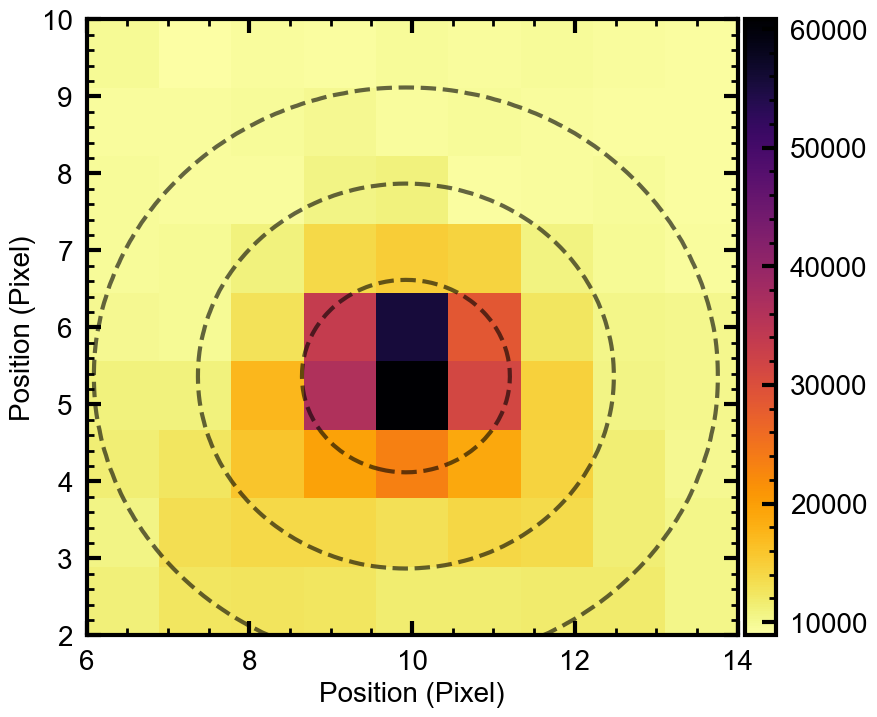

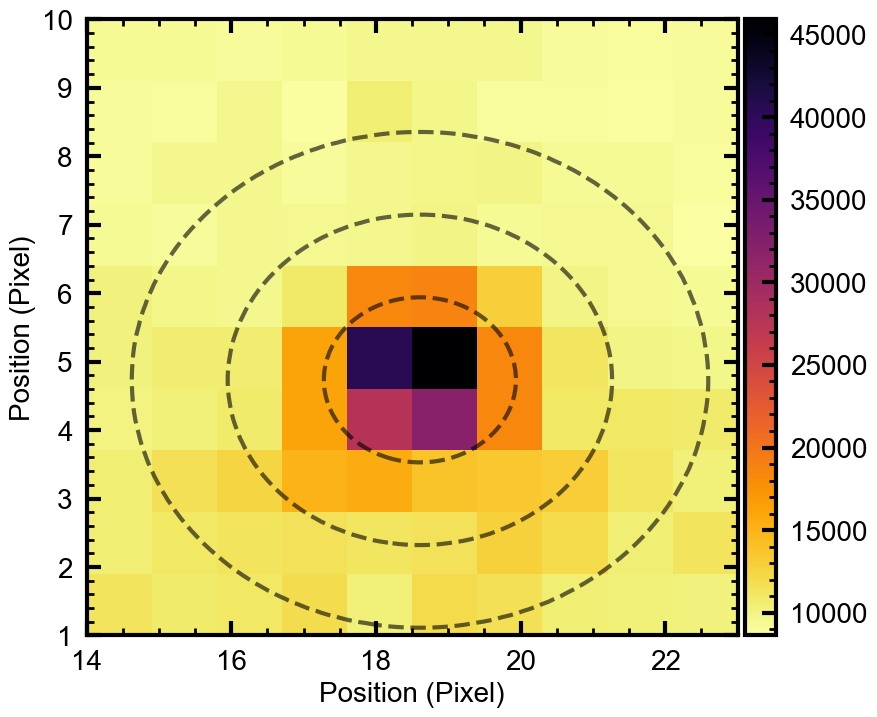

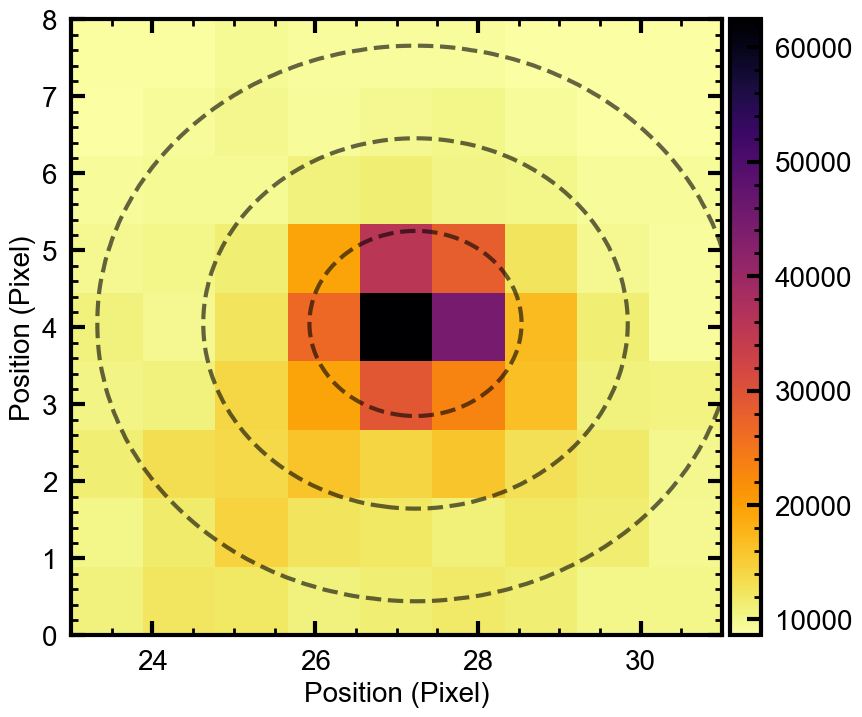

In [86]:
j = 0
filename = os.path.join(directory0,flst0[j])
data = np.load(filename)
image_array = data['image_array']
pixel_x = np.arange(image_array[0].shape[0])
pixel_y = np.arange(image_array[0].shape[1])
cummulative_image = image_array.sum(axis=0)

f = plt.figure()
ax  =f.add_subplot(111)
im = ax.pcolorfast(pixel_x,pixel_y,cummulative_image.T, cmap='inferno_r')
cb = f.colorbar(im,ax=ax,pad=0.01)
cb.ax.set_title('Intensity')
ax.set_xlabel(r'Position (Pixel)')
ax.set_ylabel(r'Position (Pixel)')


####

# position_1

xstart = 6
xend = 14
ystart = 2
yend = 10


sampled_x,sampled_y,sampled_z = sample_xyz_data(pixel_x,pixel_y,cummulative_image,xstart,xend,ystart,yend)

f = plt.figure()
ax  =f.add_subplot(111)
im = ax.pcolorfast(sampled_x ,sampled_y,sampled_z.T, cmap='inferno_r')
cb = f.colorbar(im,ax=ax,pad=0.01)
ax.set_xlabel(r'Position (Pixel)')
ax.set_ylabel(r'Position (Pixel)')

result, model = gaussian_2d_fit(sampled_x ,sampled_y,np.ravel(sampled_z),guess_params=[max(np.ravel(sampled_z)),10,8,0.5,0.5,min(np.ravel(sampled_z))])
contour_level, labels =contour_level_from_fit(result)

xpix,ypix = np.meshgrid(np.linspace(xstart,xend,101),np.linspace(ystart,yend,101))
bestfit = model.eval(result.params,xy_mesh = np.meshgrid(np.linspace(xstart,xend,101),np.linspace(ystart,yend,101)))
ax.contour(xpix,ypix,bestfit.reshape((xpix.shape[0],ypix.shape[0])).T,colors='black',alpha=0.6,levels=contour_level,linestyles ='dashed')


# position_2

xstart = 14
xend = 23
ystart = 1
yend = 10


sampled_x,sampled_y,sampled_z = sample_xyz_data(pixel_x,pixel_y,cummulative_image,xstart,xend,ystart,yend)

f = plt.figure()
ax  =f.add_subplot(111)
im = ax.pcolorfast(sampled_x ,sampled_y,sampled_z.T, cmap='inferno_r')
cb = f.colorbar(im,ax=ax,pad=0.01)
ax.set_xlabel(r'Position (Pixel)')
ax.set_ylabel(r'Position (Pixel)')

result1, model = gaussian_2d_fit(sampled_x ,sampled_y,np.ravel(sampled_z),guess_params=[max(np.ravel(sampled_z)),18,7,0.5,0.5,min(np.ravel(sampled_z))])
contour_level, labels =contour_level_from_fit(result1)

xpix,ypix = np.meshgrid(np.linspace(xstart,xend,101),np.linspace(ystart,yend,101))
bestfit = model.eval(result1.params,xy_mesh = np.meshgrid(np.linspace(xstart,xend,101),np.linspace(ystart,yend,101)))
ax.contour(xpix,ypix,bestfit.reshape((xpix.shape[0],ypix.shape[0])).T,colors='black',alpha=0.6,levels=contour_level,linestyles ='dashed')

# position_3

xstart = 23
xend = 31
ystart = 0
yend = 8


sampled_x,sampled_y,sampled_z = sample_xyz_data(pixel_x,pixel_y,cummulative_image,xstart,xend,ystart,yend)

f = plt.figure()
ax  =f.add_subplot(111)
im = ax.pcolorfast(sampled_x ,sampled_y,sampled_z.T, cmap='inferno_r')
cb = f.colorbar(im,ax=ax,pad=0.01)
ax.set_xlabel(r'Position (Pixel)')
ax.set_ylabel(r'Position (Pixel)')

result2, model = gaussian_2d_fit(sampled_x ,sampled_y,np.ravel(sampled_z),guess_params=[max(np.ravel(sampled_z)),27,4,0.5,0.5,min(np.ravel(sampled_z))])
contour_level, labels =contour_level_from_fit(result2)

xpix,ypix = np.meshgrid(np.linspace(xstart,xend,101),np.linspace(ystart,yend,101))
bestfit = model.eval(result2.params,xy_mesh = np.meshgrid(np.linspace(xstart,xend,101),np.linspace(ystart,yend,101)))
ax.contour(xpix,ypix,bestfit.reshape((xpix.shape[0],ypix.shape[0])).T,colors='black',alpha=0.6,levels=contour_level,linestyles ='dashed')



sep, dsep = separation(result,result2)
sep1, dsep1 = separation(result1,result2)
print ('2 peaks are separated by {:.3f} +- {:.3f} pixel'.format(sep, dsep))
print ('2 peaks are separated by {:.3f} +- {:.3f} pixel'.format(sep1, dsep1))
print ('3-ion string at 582 kHz axial, separation is 6.87088598 um')
print ('This gives the conversion factor of {:.3f} +- {:.3f} um/pixel'.format( 2*6.87088598/sep,  2*6.87088598*(dsep/sep)/sep))